This notebook attempts to use short-term BG-NBD and Gamma-Gamma models to model the CLTV in a short future time period.
* 可能不用这两个模型建立建立CLV，但是可以参考BG-NBD给出的短期顾客回购概率->implications on short-term strategies such as email campaigns
* 比如高clv的客户，设置更高的threshold发出邮件，在回购概率没有下降很多时就进行挽留
* 留存客户的策略，激活不活跃的还需考量。具体threshold也还要定，但是策略可以先写，参照上面一条（BG-NBD预测丢失->过threshold发警报->发targeted的东西留存）

* TBU: BG-NBD model accuracy

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import parser
from dateutil import relativedelta
from lifetimes import BetaGeoFitter
from lifetimes import ModifiedBetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.metrics import mean_squared_error
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes import GammaGammaFitter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install pymc_marketing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.5/470.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2


## 1 Data Importing

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
hotel = pd.read_csv('/content/drive/My Drive/5900/hotel.csv', sep = '|', header = None)

hotel.columns = ['CUSTOMER_ID', 'CALENDAR_YEAR', 'CALENDAR_MONTH', 'PRODUCT_CATEGORY', 'LATEST_TRANSACTION_DATE',
                 'NUM_TRANSACTIONS', 'TOTAL_SPEND', 'MARRIOTT_REVENUE']
hotel['LATEST_TRANSACTION_DATE'] = pd.to_datetime(hotel['LATEST_TRANSACTION_DATE'])
hotel.head()

,CUSTOMER_ID,CALENDAR_YEAR,CALENDAR_MONTH,PRODUCT_CATEGORY,LATEST_TRANSACTION_DATE,NUM_TRANSACTIONS,TOTAL_SPEND,MARRIOTT_REVENUE
0,313533313938323732,2013,1,Hotel Room,2013-01-12,2.0,191.41,8.00
1,313539383432323632,2008,2,Hotel Room,2008-02-14,5.0,1758.20,67.37
2,313936373136313930,2002,7,Hotel Room,2002-07-31,3.0,345.34,13.24
3,313936373136313930,2014,9,Hotel Room,2014-09-03,2.0,173.60,6.32
4,313533313938323935,2013,11,Hotel Room,2013-11-24,2.0,715.86,31.58


In [ ]:
raw_data = hotel

In [ ]:
hotel = raw_data

## 2 Needed Features

In [ ]:
# Lifetime recency
hotel['Last_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('max')
hotel['First_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('min')
hotel['LifetimeRecency'] = (hotel['Last_Transaction_Date'] - hotel['First_Transaction_Date']).dt.days
hotel.drop('Last_Transaction_Date', axis=1, inplace=True)
hotel.drop('First_Transaction_Date', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,LifetimeRecency
0,313533313938323732,5885
1,313539383432323632,7857
2,313936373136313930,7896
3,313936373136313930,7896
4,313533313938323935,4242


In [ ]:
hotel['TotalFrequency'] = hotel.groupby('CUSTOMER_ID')['NUM_TRANSACTIONS'].transform('sum')

# Filtering out customers who purchased at least two times
hotel = hotel[hotel['TotalFrequency'] >= 2]

hotel.head()

,CUSTOMER_ID,CALENDAR_YEAR,CALENDAR_MONTH,PRODUCT_CATEGORY,LATEST_TRANSACTION_DATE,NUM_TRANSACTIONS,TOTAL_SPEND,MARRIOTT_REVENUE,LifetimeRecency,TotalFrequency
0,313533313938323732,2013,1,Hotel Room,2013-01-12,2.0,191.41,8.00,5885,2757.0
1,313539383432323632,2008,2,Hotel Room,2008-02-14,5.0,1758.20,67.37,7857,1232.0
2,313936373136313930,2002,7,Hotel Room,2002-07-31,3.0,345.34,13.24,7896,3894.0
3,313936373136313930,2014,9,Hotel Room,2014-09-03,2.0,173.60,6.32,7896,3894.0
4,313533313938323935,2013,11,Hotel Room,2013-11-24,2.0,715.86,31.58,4242,50.0


In [ ]:
# Calculate FirstRecency (T)
latest_date = hotel['LATEST_TRANSACTION_DATE'].max()
hotel['First_Transaction_Date'] = hotel.groupby('CUSTOMER_ID')['LATEST_TRANSACTION_DATE'].transform('min')
hotel['FirstRecency'] = (latest_date - hotel['First_Transaction_Date']).dt.days
hotel.drop('First_Transaction_Date', axis=1, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,FirstRecency
0,313533313938323732,5917
1,313539383432323632,7886
2,313936373136313930,7928
3,313936373136313930,7928
4,313533313938323935,5738


In [ ]:
# Calculate the total revenue for each customer across all categories
total_revenue_per_customer = hotel.groupby('CUSTOMER_ID')['MARRIOTT_REVENUE'].sum().reset_index()
total_revenue_per_customer.columns = ['CUSTOMER_ID', 'TOTAL_REVENUE']
hotel = hotel.merge(total_revenue_per_customer, on='CUSTOMER_ID', how='left')
hotel.rename(columns={'TOTAL_REVENUE': 'TotalRevenue'}, inplace=True)
hotel[['CUSTOMER_ID', hotel.columns[-1]]].head()

,CUSTOMER_ID,TotalRevenue
0,313533313938323732,2131.51
1,313539383432323632,14385.69
2,313936373136313930,3884.51
3,313936373136313930,3884.51
4,313533313938323935,562.87


## 3 Picking a sample for analysis: those with transactions in 2021

In [ ]:
customers_2021_hotel = hotel[hotel['CALENDAR_YEAR'] == 2021]['CUSTOMER_ID'].nunique()
customers_2021_hotel

237661

In [ ]:
customers_before_2021_ids = hotel[(hotel['CALENDAR_YEAR'] < 2021)]['CUSTOMER_ID'].unique()
customers_2021_ids = hotel[hotel['CALENDAR_YEAR'] == 2021]['CUSTOMER_ID'].unique()
both_years_ids = set(customers_before_2021_ids) & set(customers_2021_ids)
len(both_years_ids)

114270

In [ ]:
hotel = hotel[hotel['CUSTOMER_ID'].isin(both_years_ids)]
len(hotel)

5846950

In [ ]:
hotel_features = hotel[['CUSTOMER_ID', 'LifetimeRecency', 'FirstRecency', 'TotalFrequency', 'TotalRevenue']]

## 4 BG-NBD Modelling

In [ ]:
cltv = hotel_features.drop_duplicates(subset='CUSTOMER_ID', keep='first')
cltv.set_index('CUSTOMER_ID', inplace=True)
cltv.head()

,LifetimeRecency,FirstRecency,TotalFrequency,TotalRevenue
CUSTOMER_ID,,,,
313533313938323732,5885,5917,2757.0,2131.51
313539383432323632,7857,7886,1232.0,14385.69
313936373136313930,7896,7928,3894.0,3884.51
313539383738303333,7911,7914,1828.0,15001.83
313632353135393937,7894,7926,3823.0,2067.76


In [ ]:
import datetime as dt

#today_date = dt.datetime(2023, 11, 5)

#cltv.columns = cltv.columns.droplevel(0)

cltv.columns = ['recency', 'T', 'frequency', 'monetary']

cltv = cltv[cltv['monetary'] > 0]

In [ ]:
# Suppose that monetary value is average earning per transaction
cltv['monetary'] = cltv['monetary'] / cltv['frequency']

# Transforming days to MONTHs
cltv['recency'] = cltv['recency'] / 30
cltv['T'] = cltv['T'] / 30

cltv = cltv[(cltv['frequency'] > 1)]

In [ ]:
cltv.head()

,recency,T,frequency,monetary
CUSTOMER_ID,,,,
313533313938323732,196.166667,197.233333,2757.0,0.773127
313539383432323632,261.900000,262.866667,1232.0,11.676696
313936373136313930,263.200000,264.266667,3894.0,0.997563
313539383738303333,263.700000,263.800000,1828.0,8.206690
313632353135393937,263.133333,264.200000,3823.0,0.540874


In [ ]:
cltv.describe()

,recency,T,frequency,monetary
count,114135.000000,114135.000000,114135.000000,114135.000000
mean,92.230999,99.215069,335.430718,7.898600
std,74.534455,72.444684,999.474527,29.773078
min,0.033333,21.333333,2.000000,0.000769
25%,35.100000,42.500000,15.000000,2.890399
50%,66.033333,73.100000,44.000000,4.814444
75%,133.733333,138.300000,178.000000,7.749296
max,264.700000,264.800000,30655.000000,5068.535000


In [ ]:
cltv_temp = cltv[cltv['recency']>0]
cltv_temp.describe()

,recency,T,frequency,monetary
count,114135.000000,114135.000000,114135.000000,114135.000000
mean,92.230999,99.215069,335.430718,7.898600
std,74.534455,72.444684,999.474527,29.773078
min,0.033333,21.333333,2.000000,0.000769
25%,35.100000,42.500000,15.000000,2.890399
50%,66.033333,73.100000,44.000000,4.814444
75%,133.733333,138.300000,178.000000,7.749296
max,264.700000,264.800000,30655.000000,5068.535000


In [ ]:
bgf = ModifiedBetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_temp['frequency'], cltv_temp['recency'], cltv_temp['T'])

<lifetimes.ModifiedBetaGeoFitter: fitted with 114135 subjects, a: 0.12, alpha: 0.18, b: 5.35, r: 0.52>

In [ ]:
# Top 10 customers expected to make the most purchases in 3 MONTHs
bgf.conditional_expected_number_of_purchases_up_to_time(3, # MONTH
                                                        cltv['frequency'],
                                                        cltv['recency'],
                                                        cltv['T']).sort_values(ascending=False).head(10)

CUSTOMER_ID
313632353233383832           inf
333038373134363230    451.037060
31363138343830        445.668401
313736373234353634    395.055685
3931363939303635      393.783734
313834383032343133    374.761101
323030353239333538    371.095047
323133313035343437    352.790603
313933363835303039    350.050895
323135343835333138    342.655954
dtype: float64

/usr/local/lib/python3.10/dist-packages/lifetimes/fitters/modified_beta_geo_fitter.py:184: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (a / (b + x)) * ((alpha + T) / (alpha + recency)) ** (r + x)


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

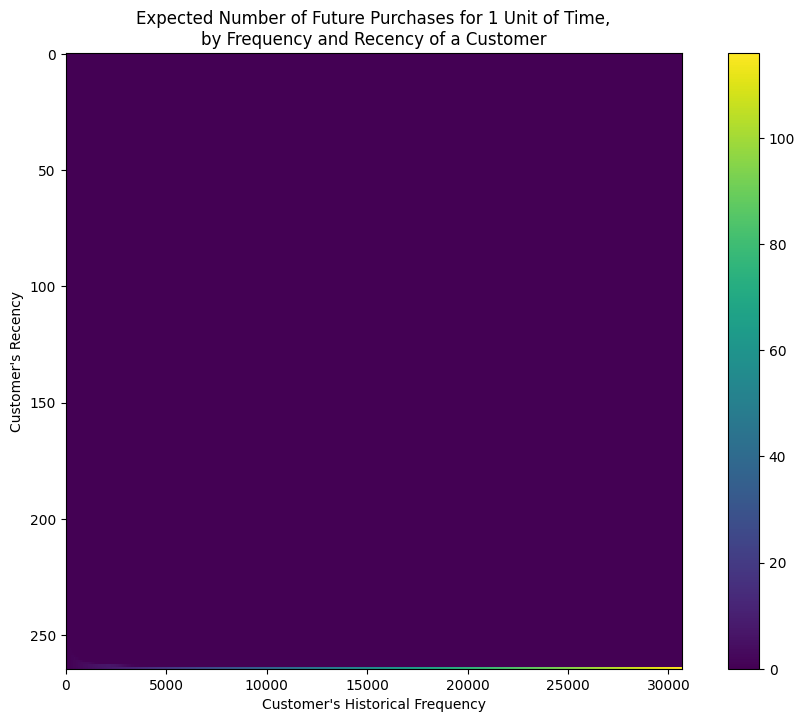

In [ ]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

/usr/local/lib/python3.10/dist-packages/lifetimes/fitters/modified_beta_geo_fitter.py:213: RuntimeWarning: overflow encountered in power
  return np.atleast_1d(1.0 / (1 + (a / (b + frequency)) * ((alpha + T) / (alpha + recency)) ** (r + frequency)))


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

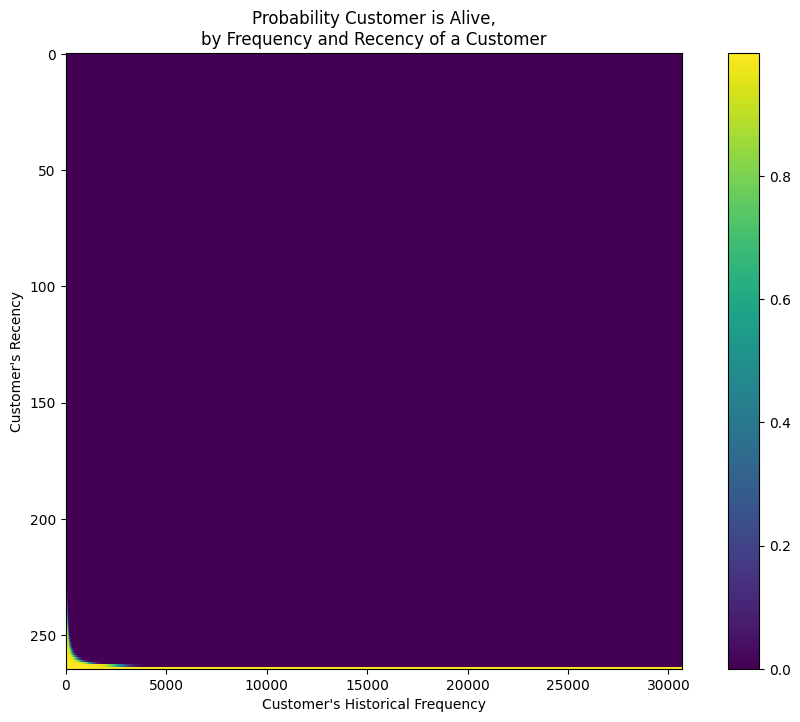

In [ ]:
#Probability of customer still alive / active?
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [ ]:
# PERIOD_LENGTH = 1

# Predict future total amount spent for individual customers (next period)
# t = PERIOD_LENGTH  # Days (1 Month aprox)
# hotel["pred_n_purchases"] = bgf.predict(
#    t, cltv_temp["frequency"], cltv_temp["recency"], cltv_temp["T"]
#)

### 4.1 BG-NBD Modelling with pymc_marketing (unfinished)

In [ ]:
customer_example = cltv.loc[3836373738373733]
customer_example

recency                 26.233333
T                       39.066667
frequency                     7.0
monetary                28.541429
cltv_pred_12_months    218.449105
cltv_group                     Q3
Name: 3836373738373733, dtype: object

In [ ]:
customer_example_history = pd.DataFrame(dict(
    ID=np.full(10, 3836373738373733, dtype="int"),
    frequency=np.full(10, customer_example["frequency"], dtype="int"),
    recency=np.full(10, customer_example["recency"]),
    T=(np.arange(-1, 9) + customer_example["T"]).astype("int"),

))
customer_example_history

,ID,frequency,recency,T
0,3836373738373733,7,26.233333,38
1,3836373738373733,7,26.233333,39
2,3836373738373733,7,26.233333,40
3,3836373738373733,7,26.233333,41
4,3836373738373733,7,26.233333,42
5,3836373738373733,7,26.233333,43
6,3836373738373733,7,26.233333,44
7,3836373738373733,7,26.233333,45
8,3836373738373733,7,26.233333,46
9,3836373738373733,7,26.233333,47


In [ ]:
import arviz as az
from pymc_marketing import clv

In [ ]:
data = cltv
data = data.rename(columns={'CUSTOMER_ID': 'customer_id'})

In [ ]:
bgm = clv.BetaGeoModel(data = data)
bgm.build_model()

In [ ]:
bgm

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

In [ ]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 10}},
}
bgm = clv.BetaGeoModel(
    data = data,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfNormal(0, 10)
         b ~ HalfNormal(0, 10)
     alpha ~ HalfNormal(0, 10)
         r ~ HalfNormal(0, 10)
likelihood ~ Potential(f(r, alpha, b, a))

In [ ]:
bgm.fit()
bgm.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.295,0.003,0.290,0.302,0.000,0.000,1108.0,1190.0,1.0
b,50.515,1.049,48.477,52.341,0.031,0.022,1130.0,1282.0,1.0
alpha,0.179,0.001,0.177,0.181,0.000,0.000,1065.0,1192.0,1.0
r,0.520,0.002,0.516,0.523,0.000,0.000,981.0,964.0,1.0


In [ ]:
clv.plot_frequency_recency_matrix(bgm);

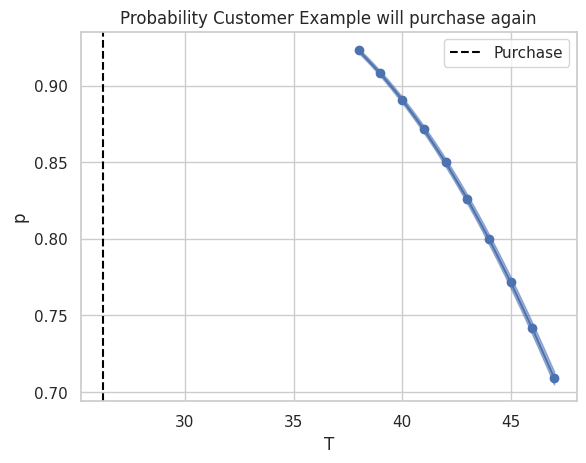

In [ ]:
p_alive = bgm.expected_probability_alive(
    customer_id=customer_example_history["ID"],
    frequency=customer_example_history["frequency"],
    recency=customer_example_history["recency"],
    T=customer_example_history["T"],
)
az.plot_hdi(customer_example_history["T"], p_alive, color="C0")
plt.plot(customer_example_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_example_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title("Probability Customer Example will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

#### Note:

We may consider a short-term strategy using something like the graph above: BG-NBD model can tell us how long it would take for a customer's probability of purchasing again drops below a certain threshold. With such prediction, we can tailor a strategy that tries to retend this customer at an appropriate time.

## 5 Gamma-Gamma Modelling

In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv['frequency'], cltv['monetary'])

<lifetimes.GammaGammaFitter: fitted with 114135 subjects, p: 1.71, q: 1.04, v: 1.67>

In [ ]:
# The top 10 customers expected to be most valuable
ggf.conditional_expected_average_profit(cltv['frequency'],
                                        cltv['monetary']).sort_values(ascending=False).head(10)

CUSTOMER_ID
3630383638383635      5007.297510
323331363639393439    3458.265517
323735363536333537    1877.353730
3437353933383935      1592.490122
313334313835353234    1545.420822
3739343239363037      1483.173432
323834323037303839    1467.657642
313132313430363239    1393.728694
313737303635323036    1376.768672
3235353632343731      1206.199185
dtype: float64

In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv['frequency'], cltv['monetary'])

## 6 Getting a customer value prediction

In [ ]:
# The customer value expected to in the next 12 months
cltv['cltv_pred_12_months'] = ggf.customer_lifetime_value(bgf,
                                   cltv['frequency'],
                                   cltv['recency'],
                                   cltv['T'],
                                   cltv['monetary'],
                                   time=12,  # 12 months
                                   freq="W",  # frequency information of T. In this case we set week by using 'W'
                                   discount_rate=0.01)

In [ ]:
cltv

,recency,T,frequency,monetary,cltv_pred_12_months
CUSTOMER_ID,,,,,
313533313938323732,196.166667,197.233333,2757.0,0.773127,4.001226
313539383432323632,261.900000,262.866667,1232.0,11.676696,2624.801738
313936373136313930,263.200000,264.266667,3894.0,0.997563,3.469873
313539383738303333,263.700000,263.800000,1828.0,8.206690,2750.787006
313632353135393937,263.133333,264.200000,3823.0,0.540874,2.404697
...,...,...,...,...,...
3836373738373733,26.233333,39.066667,7.0,28.541429,218.449105
323537303930363137,10.000000,25.300000,9.0,6.824444,2.354195
323738303333363239,14.400000,26.200000,6.0,4.236667,34.747550


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


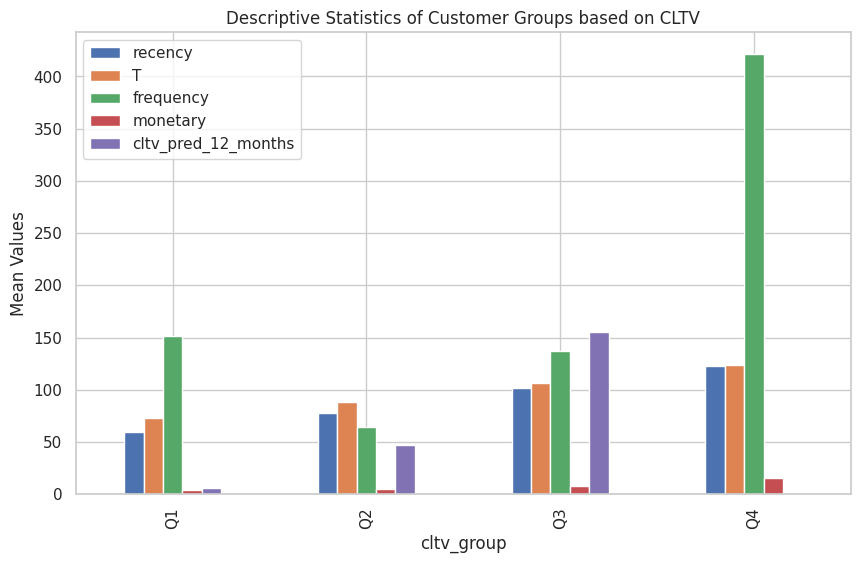

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cut the dataset into four groups using qcut on cltv_pred_12_months
cltv['cltv_group'] = pd.qcut(cltv['cltv_pred_12_months'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Visualize the descriptive statistics of each group
cltv_grouped = cltv.groupby('cltv_group').agg({'recency': 'mean', 'T': 'mean', 'frequency': 'mean', 'monetary': 'mean', 'cltv_pred_12_months': 'mean'})

# Plotting the descriptive statistics for each group
cltv_grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Descriptive Statistics of Customer Groups based on CLTV')
plt.ylabel('Mean Values')
plt.show()


In [ ]:
cltv.to_csv('BGNBD_1105.csv')